In [1]:
"""
Benchmark: 1D Schnakenberg Reaction-Diffusion System
====================================================

This benchmark compares the performance of implicit Runge-Kutta solvers
when using sparse versus dense Jacobian representations.

Problem description
-------------------
We solve the Schnakenberg reaction-diffusion system in 1D:

    ∂u/∂t = D_u ∂²u/∂x² + a - u + u²v
    ∂v/∂t = D_v ∂²v/∂x² + b - u²v

on the spatial domain x ∈ (0, 1) with homogeneous Dirichlet boundary
conditions (u = v = 0 at the boundaries). The parameters are:

    a = 0.2,    b = 1.3
    D_u = 1e-3, D_v = 5e-3

Discretization
--------------
The spatial domain is discretized with N interior points and uniform
grid spacing h = 1 / (N + 1). A standard finite-difference Laplacian
is used for the diffusion operator. This yields a system of ODEs in
time of dimension 2N:

    U = (u₁, ..., u_N, v₁, ..., v_N)ᵀ ∈ ℝ²ᴺ.

ODE System
----------
The resulting semi-discrete system is integrated in time with an
implicit Runge-Kutta scheme (SDIRK(3,4) by Nørsett-Thompson). The
benchmark compares two implementations of the Jacobian:

    • Dense Jacobian: stored and factored as a full 2N x 2N matrix.
    • Sparse Jacobian: block sparse representation with CSR format.

Goal
----
To measure the impact of Jacobian sparsity on runtime efficiency
for moderately large problems (here N = 200).

Expected behavior:
- Sparse storage/factorization should reduce computational cost and
  memory footprint compared to the dense approach.
"""

import time
import numpy as np
import scipy.sparse as sp
from scipy.sparse import diags, bmat
from matplotlib import pyplot as plt

from pyodys import ODEProblem, PyodysSolver


In [2]:


# ---------------------------------------------------------------------------
# Model parameters
# ---------------------------------------------------------------------------
a, b = 0.2, 1.3        # Schnakenberg reaction parameters
D_u, D_v = 1e-3, 5e-3  # Diffusion coefficients

# ---------------------------------------------------------------------------
# Utilities
# ---------------------------------------------------------------------------
def laplacian_1d(N: int, h: float) -> sp.csr_matrix:
    """Construct 1D Laplacian with Dirichlet BC."""
    main_diag = -2.0 * np.ones(N)
    off_diag = np.ones(N-1)
    return diags([off_diag, main_diag, off_diag], [-1,0,1], format='csr') / (h**2)

# ---------------------------------------------------------------------------
# Schnakenberg 1D problem
# ---------------------------------------------------------------------------
class Schnakenberg1D(ODEProblem):
    """1D Schnakenberg reaction-diffusion system."""
    
    def __init__(self, N: int, t_init: float, t_final: float, force_dense: bool = False):
        self.N = N
        self.h = 1.0 / (N + 1)
        self.x = np.linspace(self.h, 1.0 - self.h, N)
        self.force_dense = force_dense

        # Steady-state solution with perturbation
        u0 = a + b
        v0 = b / (a + b)**2
        rng = np.random.default_rng(12345)
        perturb = 0.02 * rng.standard_normal(size=(N,))
        U = u0 + perturb
        V = v0 + perturb
        initial_state = np.hstack([U, V])

        self.L = laplacian_1d(N, self.h)
        super().__init__(t_init, t_final, initial_state, jacobian_is_constant=False, mass_matrix_is_identity=True)

    def evaluate_at(self, t: float, U: np.ndarray) -> np.ndarray:
        u = U[:self.N]
        v = U[self.N:]
        rhs_u = D_u * self.L.dot(u) + (a - u + u**2 * v)
        rhs_v = D_v * self.L.dot(v) + (b - u**2 * v)
        return np.concatenate([rhs_u, rhs_v])

    def jacobian_at(self, t: float, U: np.ndarray):
        u = U[:self.N]
        v = U[self.N:]
        n = self.N
        if self.force_dense:
            J = np.zeros((2*n, 2*n))
            J[:n,:n] = D_u*self.L.toarray() + np.diag(-1 + 2*u*v)
            J[:n,n:] = np.diag(u**2)
            J[n:,:n] = np.diag(-2*u*v)
            J[n:,n:] = D_v*self.L.toarray() + np.diag(-u**2)
            return J
        else:
            R_uu = diags(-1 + 2*u*v, 0, format='csr')
            R_uv = diags(u**2, 0, format='csr')
            R_vu = diags(-2*u*v, 0, format='csr')
            R_vv = diags(-u**2, 0, format='csr')
            A11 = D_u * self.L + R_uu
            A12 = R_uv
            A21 = R_vu
            A22 = D_v * self.L + R_vv
            return bmat([[A11,A12],[A21,A22]], format='csr')



In [3]:
# ---------------------------------------------------------------------------
# Benchmark setup
# ---------------------------------------------------------------------------
N = 200
t_init, t_final = 0.0, 2.0

prob_sparse = Schnakenberg1D(N, t_init, t_final, force_dense=False)
prob_dense  = Schnakenberg1D(N, t_init, t_final, force_dense=True)

solver_opts = {
    "method": "sdirk43",
    "first_step": 1e-6,
    "adaptive": True,
    "min_step": 1e-8,
    "max_step": 5e-1,
    "atol": 1e-8,
    "rtol": 1e-8
}

solver_sparse = PyodysSolver(auto_check_sparsity =True, **solver_opts)
solver_dense  = PyodysSolver(auto_check_sparsity =False, **solver_opts)

# ---------------------------------------------------------------------------
# Solve
# ---------------------------------------------------------------------------
t0 = time.perf_counter()
times_sparse, sols_sparse = solver_sparse.solve(prob_sparse)
elapsed_sparse = time.perf_counter() - t0

t0 = time.perf_counter()
times_dense, sols_dense = solver_dense.solve(prob_dense)
elapsed_dense = time.perf_counter() - t0

print(f"Sparse solver CPU time: {elapsed_sparse:.3f} s")
print(f"Dense solver CPU time:  {elapsed_dense:.3f} s")



Sparse solver CPU time: 0.360 s
Dense solver CPU time:  91.203 s


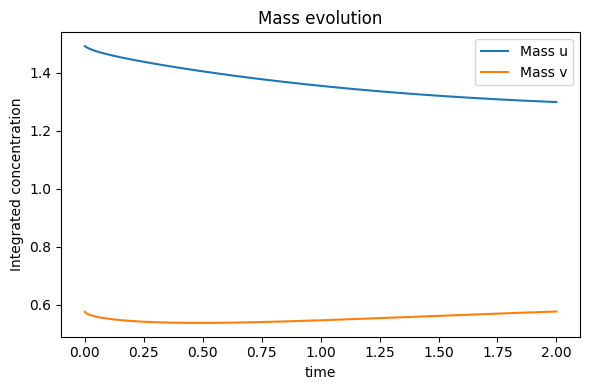

In [4]:
# ---------------------------------------------------------------------------
# Mass evolution
# ---------------------------------------------------------------------------
U_all = sols_sparse[:, :N]
V_all = sols_sparse[:, N:]

mass_u = U_all @ np.ones(N) * prob_sparse.h
mass_v = V_all @ np.ones(N) * prob_sparse.h

plt.figure(figsize=(6,4))
plt.plot(times_sparse, mass_u, label='Mass u')
plt.plot(times_sparse, mass_v, label='Mass v')
plt.xlabel('time')
plt.ylabel('Integrated concentration')
plt.title('Mass evolution')
plt.legend()
plt.tight_layout()
plt.show()



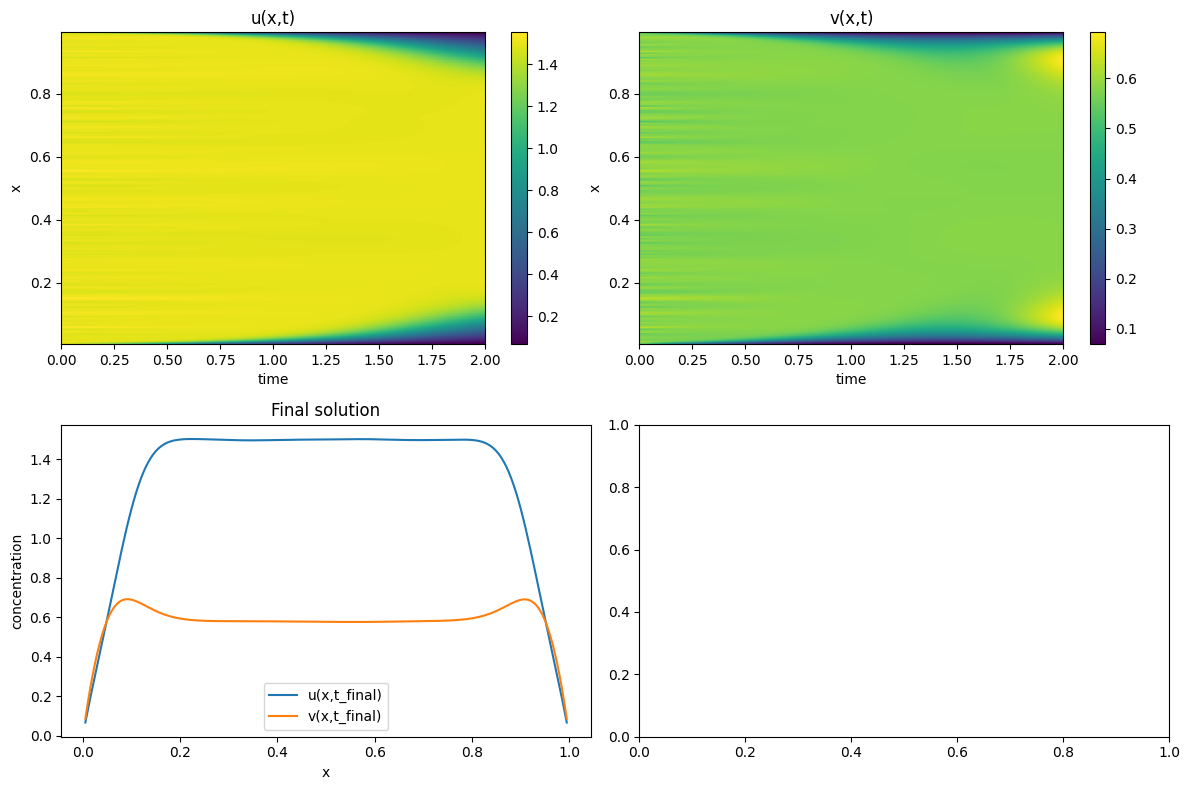

In [5]:
# ---------------------------------------------------------------------------
# Spatio-temporal solution
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(2,2, figsize=(12,8))

# Heatmap u
im1 = axes[0,0].imshow(U_all.T, extent=[t_init, t_final, prob_sparse.x[0], prob_sparse.x[-1]],
                        aspect='auto', origin='lower', cmap='viridis')
axes[0,0].set_title("u(x,t)")
axes[0,0].set_xlabel("time")
axes[0,0].set_ylabel("x")
fig.colorbar(im1, ax=axes[0,0])

# Heatmap v
im2 = axes[0,1].imshow(V_all.T, extent=[t_init, t_final, prob_sparse.x[0], prob_sparse.x[-1]],
                        aspect='auto', origin='lower', cmap='viridis')
axes[0,1].set_title("v(x,t)")
axes[0,1].set_xlabel("time")
axes[0,1].set_ylabel("x")
fig.colorbar(im2, ax=axes[0,1])

# Final snapshot
axes[1,0].plot(prob_sparse.x, U_all[-1], label='u(x,t_final)')
axes[1,0].plot(prob_sparse.x, V_all[-1], label='v(x,t_final)')
axes[1,0].set_title("Final solution")
axes[1,0].set_xlabel("x")
axes[1,0].set_ylabel("concentration")
axes[1,0].legend()

plt.tight_layout()
plt.show()



In [ ]:
def _get_dorpri85():
    C = [0.0, 0.526001519587677318785587544488e-01, 0.789002279381515978178381316732e-01, 0.118350341907227396726757197510, 0.281649658092772603273242802490, 0.333333333333333333333333333333, 0.25, 0.307692307692307692307692307692, 0.651282051282051282051282051282, 0.6, 0.857142857142857142857142857142, 1.0, 1.0, 0.1, 0.2, 0.777777777777777777777777777778]
    N_STAGES = 12
    N_STAGE_EXTENDED = 16
    A = [[0.0]*N_STAGE_EXTENDED for _ in range(N_STAGE_EXTENDED)]
    A[1][0] = 5.26001519587677318785587544488e-2
    A[2][0] = 1.97250569845378994544595329183e-2; A[2][1] = 5.91751709536136983633785987549e-2
    A[3][0] = 2.95875854768068491816892993775e-2; A[3][2] = 8.87627564304205475450678981324e-2
    A[4][0] = 2.41365134159266685502369798665e-1; A[4][2] = -8.84549479328286085344864962717e-1; A[4][3] = 9.24834003261792003115737966543e-1
    A[5][0] = 3.7037037037037037037037037037e-2; A[5][3] = 1.70828608729473871279604482173e-1; A[5][4] = 1.25467687566822425016691814123e-1
    A[6][0] = 3.7109375e-2; A[6][3] = 1.70252211019544039314978060272e-1; A[6][4] = 6.02165389804559606850219397283e-2; A[6][5] = -1.7578125e-2
    A[7][0] = 3.70920001185047927108779319836e-2; A[7][3] = 1.70383925712239993810214054705e-1; A[7][4] = 1.07262030446373284651809199168e-1; A[7][5] = -1.53194377486244017527936158236e-2; A[7][6] = 8.27378916381402288758473766002e-3
    A[8][0] = 6.24110958716075717114429577812e-1; A[8][3] = -3.36089262944694129406857109825; A[8][4] = -8.68219346841726006818189891453e-1; A[8][5] = 2.75920996994467083049415600797e1; A[8][6] = 2.01540675504778934086186788979e1; A[8][7] = -4.34898841810699588477366255144e1
    A[9][0] = 4.77662536438264365890433908527e-1; A[9][3] = -2.48811461997166764192642586468; A[9][4] = -5.90290826836842996371446475743e-1; A[9][5] = 2.12300514481811942347288949897e1; A[9][6] = 1.52792336328824235832596922938e1; A[9][7] = -3.32882109689848629194453265587e1; A[9][8] = -2.03312017085086261358222928593e-2
    A[10][0] = -9.3714243008598732571704021658e-1; A[10][3] = 5.18637242884406370830023853209; A[10][4] = 1.09143734899672957818500254654; A[10][5] = -8.14978701074692612513997267357; A[10][6] = -1.85200656599969598641566180701e1; A[10][7] = 2.27394870993505042818970056734e1; A[10][8] = 2.49360555267965238987089396762; A[10][9] = -3.0467644718982195003823669022
    A[11][0] = 2.27331014751653820792359768449; A[11][3] = -1.05344954667372501984066689879e1; A[11][4] = -2.00087205822486249909675718444; A[11][5] = -1.79589318631187989172765950534e1; A[11][6] = 2.79488845294199600508499808837e1; A[11][7] = -2.85899827713502369474065508674; A[11][8] = -8.87285693353062954433549289258; A[11][9] = 1.23605671757943030647266201528e1; A[11][10] = 6.43392746015763530355970484046e-1
    A[12][0] = 5.42937341165687622380535766363e-2; A[12][5] = 4.45031289275240888144113950566; A[12][6] = 1.89151789931450038304281599044; A[12][7] = -5.8012039600105847814672114227; A[12][8] = 3.1116436695781989440891606237e-1; A[12][9] = -1.52160949662516078556178806805e-1; A[12][10] = 2.01365400804030348374776537501e-1; A[12][11] = 4.47106157277725905176885569043e-2
    A[13][0] = 5.61675022830479523392909219681e-2; A[13][6] = 2.53500210216624811088794765333e-1; A[13][7] = -2.46239037470802489917441475441e-1; A[13][8] = -1.24191423263816360469010140626e-1; A[13][9] = 1.5329179827876569731206322685e-1; A[13][10] = 8.20105229563468988491666602057e-3; A[13][11] = 7.56789766054569976138603589584e-3; A[13][12] = -8.298e-3
    A[14][0] = 3.18346481635021405060768473261e-2; A[14][5] = 2.83009096723667755288322961402e-2; A[14][6] = 5.35419883074385676223797384372e-2; A[14][7] = -5.49237485713909884646569340306e-2; A[14][10] = -1.08347328697249322858509316994e-4; A[14][11] = 3.82571090835658412954920192323e-4; A[14][12] = -3.40465008687404560802977114492e-4; A[14][13] = 1.41312443674632500278074618366e-1
    A[15][0] = -4.28896301583791923408573538692e-1; A[15][5] = -4.69762141536116384314449447206; A[15][6] = 7.68342119606259904184240953878; A[15][7] = 4.06898981839711007970213554331; A[15][8] = 3.56727187455281109270669543021e-1; A[15][12] = -1.39902416515901462129418009734e-3; A[15][13] = 2.9475147891527723389556272149; A[15][14] = -9.15095847217987001081870187138
    b = A[N_STAGES][:N_STAGES]
    # E3 = np.zeros(N_STAGES + 1)
    # E3[:-1] = B.copy()
    # E3[0] -= 0.244094488188976377952755905512
    # E3[8] -= 0.733846688281611857341361741547
    # E3[11] -= 0.220588235294117647058823529412e-1
    E5 = [0.0]*N_STAGES
    E5[0] = 0.1312004499419488073250102996e-1
    E5[5] = -0.1225156446376204440720569753e+1
    E5[6] = -0.4957589496572501915214079952
    E5[7] = 0.1664377182454986536961530415e+1
    E5[8] = -0.3503288487499736816886487290
    E5[9] = 0.3341791187130174790297318841
    E5[10] = 0.8192320648511571246570742613e-1
    E5[11] = -0.2235530786388629525884427845e-1
    bh5 = [b[i]-E5[i] for i in range(N_STAGES)]
    # bh3 = B - E3
    B = [b, bh5]
    print(A[:N_STAGES][:N_STAGES])
    return {
        "A": [row[:N_STAGES] for row in A[:N_STAGES]],
        "B": [b, bh5],
        "C": C,
        "order": 8,
        "embedded_order": 5,
        "a_stable": False
    }

In [8]:
d = _get_dorpri85()
print(len(d['A'][0]))

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.05260015195876773, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0197250569845379, 0.0591751709536137, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.02958758547680685, 0.0, 0.08876275643042054, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.2413651341592667, 0.0, -0.8845494793282861, 0.924834003261792, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.037037037037037035, 0.0, 0.0, 0.17082860872947386, 0.12546768756682242, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.037109375, 0.0, 0.0, 0.17025221101954405, 0.06021653898045596, -0.017578125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.03709200011850479, 0.0, 0.0, 0.17038392571223998, 0.10726203044637328, -0.015319437748624402, 0.008273789163814023, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.6241109587160757, 0.0, 0.0, -3.36089

In [ ]:
d = 